# Titanic : Machine Learning from Disaster

In this notebook, we are going to create an algorithm which will predict  if a passenger of the titanic survived or not. This algorithm will learn from train dataset and then it will predict if each passenger of the test dataset survived. 

The plan to do that is the following one :

1. Exploration of data
2. Features engineering
3. Testing several models
4. Choosing best model using k folds cross validation
5. Prediction on test data & submission on kaggle

## Imports and useful functions

In [1]:
import pandas as pd
import matplotlib
import pydot
import re
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

Using TensorFlow backend.


In [2]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')

def display_confusion_matrix(sample_test, prediction, score=None):
    cm = metrics.confusion_matrix(sample_test, prediction)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    if score:
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size = 15)
    print(metrics.classification_report(sample_test, prediction))
    
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz"""
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# Function with standardize a dataframe by setting mean to 0 and var to 1
def standardize(df, target=None, categorical=None):
    
    standardize_df = df
    
    if target:
        target_serie = standardize_df[target] # Separating out the target before standardizing
        standardize_df = standardize_df.drop([target],  axis=1)
    
    if categorical:
        cat_serie = standardize_df[categorical] # Separating out categorical feature(s) before standardizing
        standardize_df = standardize_df.drop([categorical],  axis=1)

    # Standardizing the features
    scaled_values = StandardScaler().fit_transform(standardize_df.values)
    standardize_df = pd.DataFrame(scaled_values, index=standardize_df.index, columns=standardize_df.columns)
    
    if target:
        standardize_df = standardize_df.join(target_serie)
        
    if categorical:
        standardize_df = standardize_df.join(cat_serie)
    
    return standardize_df

## 1. Data exploration

In [3]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
draw_missing_data_table(train_df_raw)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


There is 77% of missing data in the cabin column, it's way too much for this column to be exploitable, so we'll remove it from the dataframe. For the age, we will either interpolate missing values or we will fill it with the median. There is only two missing values for the embarked column, let's replace them by the most recurrent value of Embarqued variable :

In [7]:
train_df_raw['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

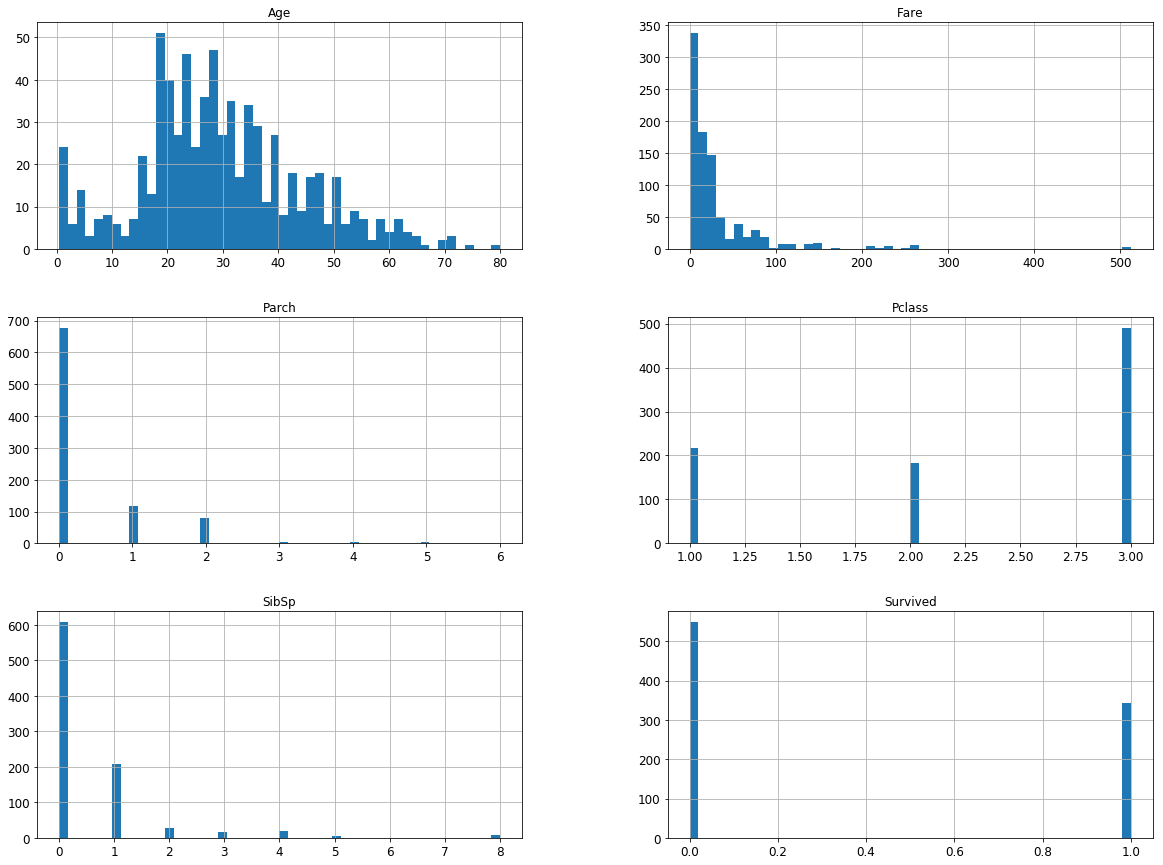

In [8]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_raw.drop(['PassengerId'], 1).hist(bins=50, figsize=(20,15))
plt.show()

With this first exploration, we can see that :

* Only aproximately 35% of passengers survived ...
* More than the half of passengers are in the lowest class (pclass = 3)
* Most of the fare tickets are below 50
* Majority of passengers are alone (sibsp and parch)

## 2. Features engineering

In [9]:
def preprocess_data(df):
    
    processed_df = df
    
    # Drop useless columns
    processed_df = processed_df.drop(['PassengerId'], 1)
    
    # Deal with missing values
    processed_df['Embarked'].fillna('S', inplace=True)
    processed_df['Age'].fillna(processed_df['Age'].mean(), inplace=True)
    processed_df['Age'] = processed_df['Age'].astype(int)
    processed_df['Fare'] = processed_df['Fare'].interpolate()
    processed_df['Cabin'].fillna('U0', inplace=True)
    
    # feature engineering on columns
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in train_df_raw['Name']), index=train_df_raw.index)
    processed_df['Title'] = processed_df['Title'].replace('the Countess', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Lady', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['Title'] = processed_df['Title'].replace('Mlle', 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Don', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Col', 'Master')
    processed_df['Title'] = processed_df['Title'].replace('Major', 'Master')
    processed_df['Title'] = processed_df['Title'].replace('Sir', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Capt', 'Mr')
    processed_df['Title'] = processed_df['Title'].replace('Ms', 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Jonkheer', 'Mr')
    processed_df['Title'] = processed_df['Title'].map({title: pos for pos, title in enumerate(set(title for title in processed_df['Title']))})
    
    processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
    processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    processed_df['Familly'] = processed_df['SibSp'] + processed_df['Parch']
    processed_df['IsAlone'] = np.where(processed_df['Familly']!=0, 0, 1)
    
    # Modify the ticket column to keep only the ticket number
    ticket_numbers = list()
    for ticket in processed_df['Ticket']:
        try:
            ticket_numbers.append(int(ticket))
        except ValueError:
            splitted = ticket.split(' ')
            if len(splitted) == 1:
                ticket_numbers.append(0)
            else:
                ticket_numbers.append(int(splitted[len(splitted)-1]))
    processed_df['Ticket'] = pd.Series(ticket_numbers, index=df.index)
    
    #Creation of a deck column corresponding to the letter contained in the cabin value
    processed_df['Deck'] = pd.Series(([cab[:1] for cab in processed_df['Cabin']]), index=processed_df.index)
    processed_df['Deck'] = processed_df['Deck'].replace('T', 'U')
    processed_df['Deck'] = processed_df['Deck'].map({title: pos for pos, title in enumerate(set(deck for deck in processed_df['Deck']))})
    
    processed_df = processed_df.drop(['Name', 'Cabin'], 1)    
    
    return processed_df

## 3. Try several models on train dataset

In [10]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df = train_df_raw.copy()
X = train_df.drop(['Survived'], 1)
Y = train_df['Survived']

# Split dataset for prediction
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)
X_train = standardize(X_train)
X_test = standardize(X_test)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Familly,IsAlone,Deck
331,-1.614136,-0.724310,1.201713,-0.470722,-0.479342,-0.285726,-0.078684,-0.548035,-0.283984,-0.554666,0.812203,-1.059864
733,-0.400551,-0.724310,-0.491364,-0.470722,-0.479342,-0.413424,-0.377145,-0.548035,-0.283984,-0.554666,0.812203,-0.156124
382,0.813034,-0.724310,0.201258,-0.470722,-0.479342,4.223884,-0.474867,-0.548035,-0.283984,-0.554666,0.812203,-0.156124
704,0.813034,-0.724310,-0.260490,0.379923,-0.479342,0.071907,-0.476230,-0.548035,-0.283984,0.040096,-1.231219,-0.156124
813,0.813034,1.380624,-1.799652,2.931860,2.048742,0.067466,-0.025249,-0.548035,-0.932050,3.013909,-1.231219,-0.156124


### 1.1 Logistic regression

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

   micro avg       0.79      0.79      0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



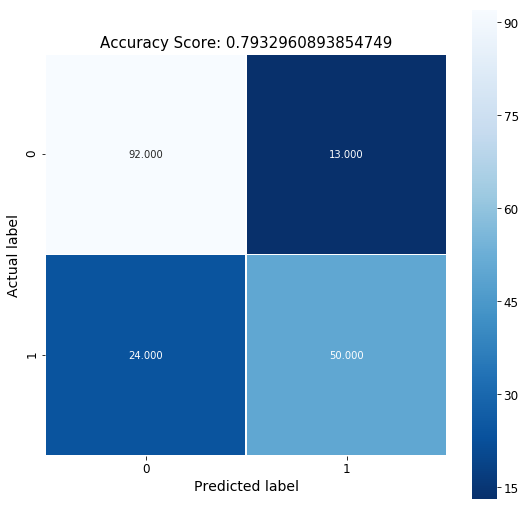

In [11]:
# Create and train model on train data sample
logisticRegr = LogisticRegression(random_state=42)
logisticRegr.fit(X_train, Y_train)

# Predict for test data sample
logistic_prediction = logisticRegr.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, logistic_prediction)
display_confusion_matrix(Y_test, logistic_prediction, score=score)

### 1.2 Decision tree

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       105
           1       0.78      0.68      0.72        74

   micro avg       0.79      0.79      0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.78       179



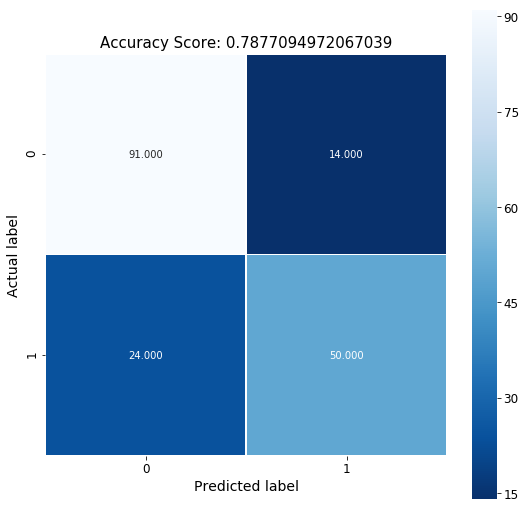

In [12]:
# Create and train model on train data sample
dt = DecisionTreeClassifier(min_samples_split=15, min_samples_leaf=20, random_state=42)
dt.fit(X_train, Y_train)

# Predict for test data sample
dt_prediction = dt.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, dt_prediction)
display_confusion_matrix(Y_test, dt_prediction, score=score)


In [13]:
visualize_tree(dt, X_test.columns)
! dot -Tpng dt.dot > dt.png

![title](dt.png)

### 1.3 Random forest

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       105
           1       0.80      0.70      0.75        74

   micro avg       0.80      0.80      0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



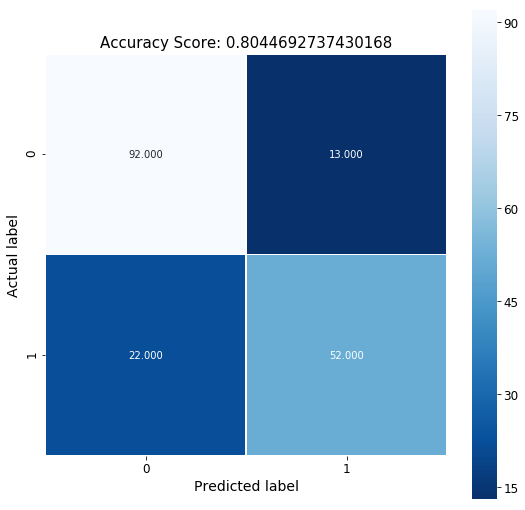

In [14]:
# Create and train model on train data sample
rf = RandomForestClassifier(n_estimators=1000, max_depth=8, min_samples_leaf=2, random_state=42)
rf.fit(X_train, Y_train)

# Predict for test data sample
rf_prediction = rf.predict(X_test)

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, rf_prediction)
display_confusion_matrix(Y_test, rf_prediction, score=score)

### 1.4 Artificial neural network

In [15]:
def build_ann(optimizer='adam'):
    # Initializing our ANN
    ann = Sequential()
    # Adding the input layer and the first hidden layer of our ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_normal', activation='relu', input_shape = (12,)))
    ann.add(Dropout(p=0.5)) 
    ann.add(Dense(units=64, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=128, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=164, kernel_initializer='glorot_normal', activation='relu'))
    ann.add(Dropout(p=0.5))
    ann.add(Dense(units=16, kernel_initializer='glorot_normal', activation='relu'))
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_normal', activation='sigmoid'))
    
    # Compilling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [16]:
ann = build_ann()
# Training the ANN
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.2, min_lr=0.00001)
ann.fit(X_train, Y_train, batch_size=10, epochs=100, callbacks=[learning_rate_reduction])

Epoch 1/100
712/712 [==============================] - 1s 1ms/step - loss: 0.6830 - acc: 0.6053
Epoch 2/100
712/712 [==============================] - 0s 333us/step - loss: 0.6531 - acc: 0.6306
Epoch 3/100
712/712 [==============================] - 0s 367us/step - loss: 0.6343 - acc: 0.6503
Epoch 4/100
712/712 [==============================] - 0s 392us/step - loss: 0.5638 - acc: 0.7346
Epoch 5/100
712/712 [==============================] - 0s 346us/step - loss: 0.5685 - acc: 0.7205
Epoch 6/100
712/712 [==============================] - 0s 361us/step - loss: 0.5430 - acc: 0.7640
Epoch 7/100
712/712 [==============================] - 0s 337us/step - loss: 0.5271 - acc: 0.7697
Epoch 8/100
712/712 [==============================] - 0s 366us/step - loss: 0.5577 - acc: 0.7556
Epoch 9/100
712/712 [==============================] - 0s 335us/step - loss: 0.4946 - acc: 0.7879
Epoch 10/100
712/712 [==============================] - 0s 358us/step - loss: 0.5237 - acc: 0.7963
Epoch 11/100
712/712 

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

   micro avg       0.80      0.80      0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



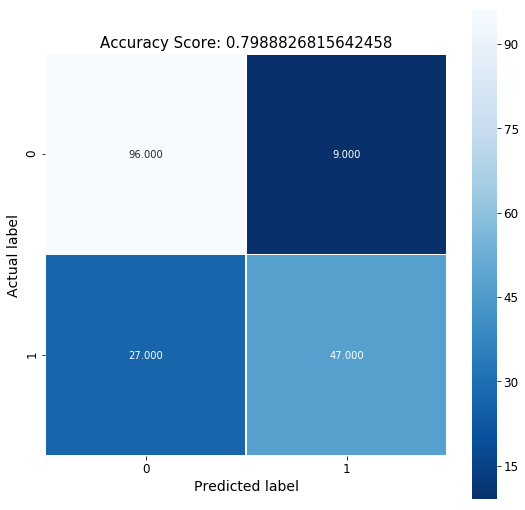

In [17]:
# Predicting the Test set results
ann_prediction = ann.predict(X_test)
ann_prediction = (ann_prediction > 0.5) # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
score = metrics.accuracy_score(Y_test, ann_prediction)
display_confusion_matrix(Y_test, ann_prediction, score=score)

## 4. Finding the best model using k-folds cross validation

The precision we calculated above does not mean anything. In gact, if we execute each cell again, we could have sightly different accuracy, because we trained again our models ! We need to verify which model has the best accuracy over several training steps ! We can do it using cross validation methods.

In [22]:
accuracies_logreg = cross_val_score(estimator=logisticRegr, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_tree = cross_val_score(estimator=dt, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_rf = cross_val_score(estimator=rf, X=X_train, y=Y_train, cv=10, n_jobs=-1)
accuracies_ann = cross_val_score(estimator=KerasClassifier(build_fn=build_ann, batch_size=10, epochs=100, verbose=0),
                                 X=X_train, y=Y_train, cv=10, n_jobs=1)

In [23]:
accuracies = {'lg': accuracies_logreg, 'dt': accuracies_tree, 'rf': accuracies_rf, 'ann': accuracies_ann}
mean = {model: acc.mean() for model, acc in accuracies.items()}
variance = {model: acc.std() for model, acc in accuracies.items()}
print('Mean accuracy:', mean, '\nVariance:', variance)

Mean accuracy: {'lg': 0.8089649005141963, 'dt': 0.8175340934495864, 'rf': 0.8288240554437737, 'ann': 0.8342722979439816} 
Variance: {'lg': 0.0653379770894721, 'dt': 0.06409109305606034, 'rf': 0.05027542491753198, 'ann': 0.044862179022006225}


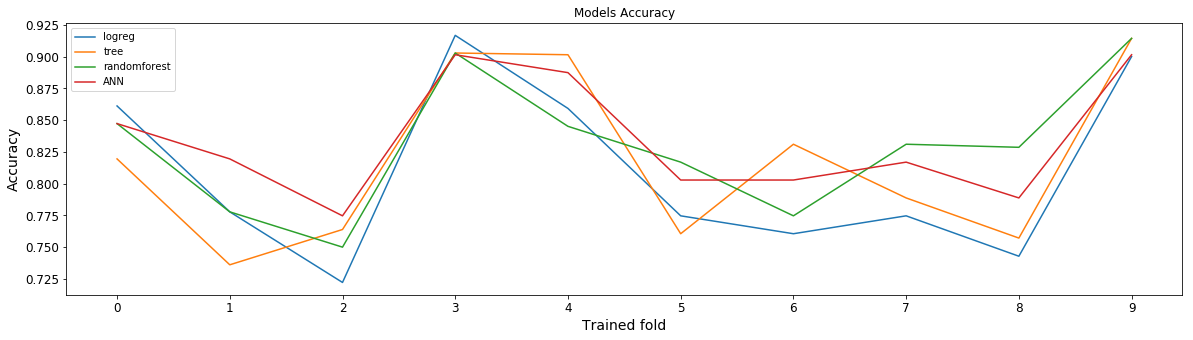

In [24]:
plt.figure(figsize=(20,5))
plt.plot(accuracies['lg'])
plt.plot(accuracies['dt'])
plt.plot(accuracies['rf'])
plt.plot(accuracies['ann'])
plt.title('Models Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Trained fold')
plt.xticks([k for k in range(10)])
plt.legend(['logreg', 'tree', 'randomforest', 'ANN'], loc='upper left')
plt.show()

Our ann seems to be the best model : it has the best accuracy and the lowest variance ! Let's make a prediction on test dataset now :)

## 5. Apply the best model on test dataset and submit on kaggle 

In [25]:
test_df_raw = pd.read_csv(path_test)
test = test_df_raw.copy()
test = preprocess_data(test)
test = standardize(test)
train = train_df_raw.copy()
answer = train['Survived']
train.drop(['Survived'], 1, inplace=True)
train = preprocess_data(train)
train = standardize(train)

In [28]:
# Create and train model on train data sample
model_test = build_ann()
model_test.fit(train, answer, batch_size=10, epochs=100, callbacks=[learning_rate_reduction])

# Predict for test data sample
prediction = model_test.predict(test)
prediction = (prediction > 0.5)*1

result_df = test_df_raw.copy()
result_df['Survived'] = prediction
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)

Epoch 1/100
891/891 [==============================] - 9s 11ms/step - loss: 0.6886 - acc: 0.6016
Epoch 2/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6200 - acc: 0.6633
Epoch 3/100
891/891 [==============================] - 1s 1ms/step - loss: 0.6048 - acc: 0.6914
Epoch 4/100
891/891 [==============================] - 1s 1ms/step - loss: 0.5574 - acc: 0.7475
Epoch 5/100
891/891 [==============================] - 1s 2ms/step - loss: 0.5479 - acc: 0.7643
Epoch 6/100
891/891 [==============================] - 2s 2ms/step - loss: 0.5082 - acc: 0.7710
Epoch 7/100
891/891 [==============================] - 1s 2ms/step - loss: 0.5185 - acc: 0.7609
Epoch 8/100
891/891 [==============================] - 1s 1ms/step - loss: 0.4989 - acc: 0.7924
Epoch 9/100
891/891 [==============================] - 1s 1ms/step - loss: 0.4847 - acc: 0.7879
Epoch 10/100
891/891 [==============================] - 1s 1ms/step - loss: 0.4856 - acc: 0.7856
Epoch 11/100
891/891 [================

In [29]:
result_df[['PassengerId', 'Survived']].head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
